# Loading data and model

In [114]:
import torch 
from XTSCBench.ClassificationModels.CNN_T import ResNetBaseline, UCRDataset,fit, get_all_preds

from XTSCBench.ClassificationModels.LSTM import LSTM
from XTSCBench.CounterfactualEvaluation import CounterfactualEvaluation
from tslearn.datasets import UCR_UEA_datasets
import sklearn
import numpy as np 
import os


In [119]:
dataset='Epilepsy' # ECG200, ECG5000, Epilepsy
# dataset = 'ptbxl'

In [120]:



if dataset in ['ECG200','ECG5000','Epilepsy']:
    train_x, train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
elif dataset == 'ptbxl':
    train_x = np.load(f'./datasets/ptbxl/x_train.npy')
    train_y = np.load(f'./datasets/ptbxl/y_train.npy')
    test_x = np.load(f'./datasets/ptbxl/x_test.npy')
    test_y = np.load(f'./datasets/ptbxl/y_test.npy')

# 1 hot encoding outcomes
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))    

n_pred_classes =train_y.shape[1]
NumTimesteps = train_x.shape[-2]
NumFeatures = train_x.shape[-1]

#For use with CNN reverse Data Dimensions
# Note that (samples, timesteps, features) -> (samples, features, timesteps) for CNN models
train_dataset = UCRDataset(train_x.astype(np.float64).reshape(-1,NumFeatures,NumTimesteps),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64).reshape(-1,NumFeatures,NumTimesteps),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)


In [117]:
# Loading model
model_name = f'cnn_{dataset}'
model_path = './trained_models'

if os.path.isfile(f'./{model_path}/{model_name}'):
    model = ResNetBaseline(in_channels=NumFeatures, num_pred_classes=n_pred_classes)
    model = torch.load(f'./{model_path}/{model_name}')
    print(f"Model {model_name} successfully loaded")
else:
    print("Model not found. Please train model using training_models.ipynb and provide in this notebook")

model.eval()

Model cnn_Epilepsy successfully loaded


ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(3, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(3, 64, kernel_size=(1,)

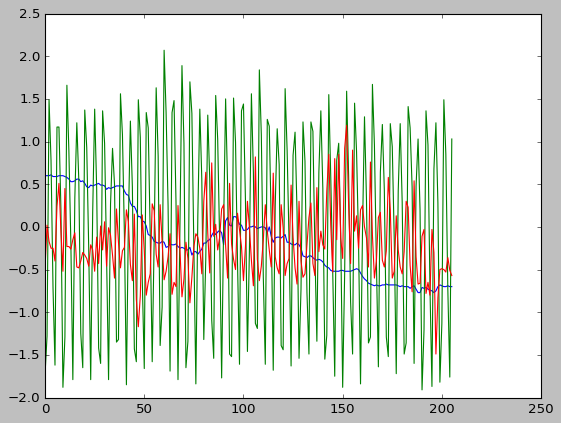

In [ ]:
import matplotlib.pyplot as plt

# plt.plot(test_x[0])

In [69]:
model.eval()
y_pred,labels= get_all_preds(model,test_loader)

In [70]:
# Selecting a sample to explain

observation_01, label_01 = test_dataset[0]
label_01=np.array([y_pred[0]])
print(observation_01.shape)
print(label_01.shape)

(3, 206)
(1,)


In [76]:
observation_01.reshape(1,3,-1).shape

(1, 3, 206)

In [83]:
observation_01[np.newaxis].shape

(1, 3, 206)

# Explaining Outcomes

## 1. TSevo

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt


In [72]:
from TSInterpret.InterpretabilityModels.counterfactual.TSEvoCF import TSEvo

tsevo_exp = TSEvo(model= model,data=(train_x,train_y), mode = 'feat',backend='PYT',epochs=500)

y was one Hot Encoded


In [84]:
# explaining the outcome of a sample
pop,label_cf=tsevo_exp.explain(observation_01[np.newaxis],np.array(label_01))

No Target


In [85]:
label_cf.shape, pop.shape

((4,), (3, 206))

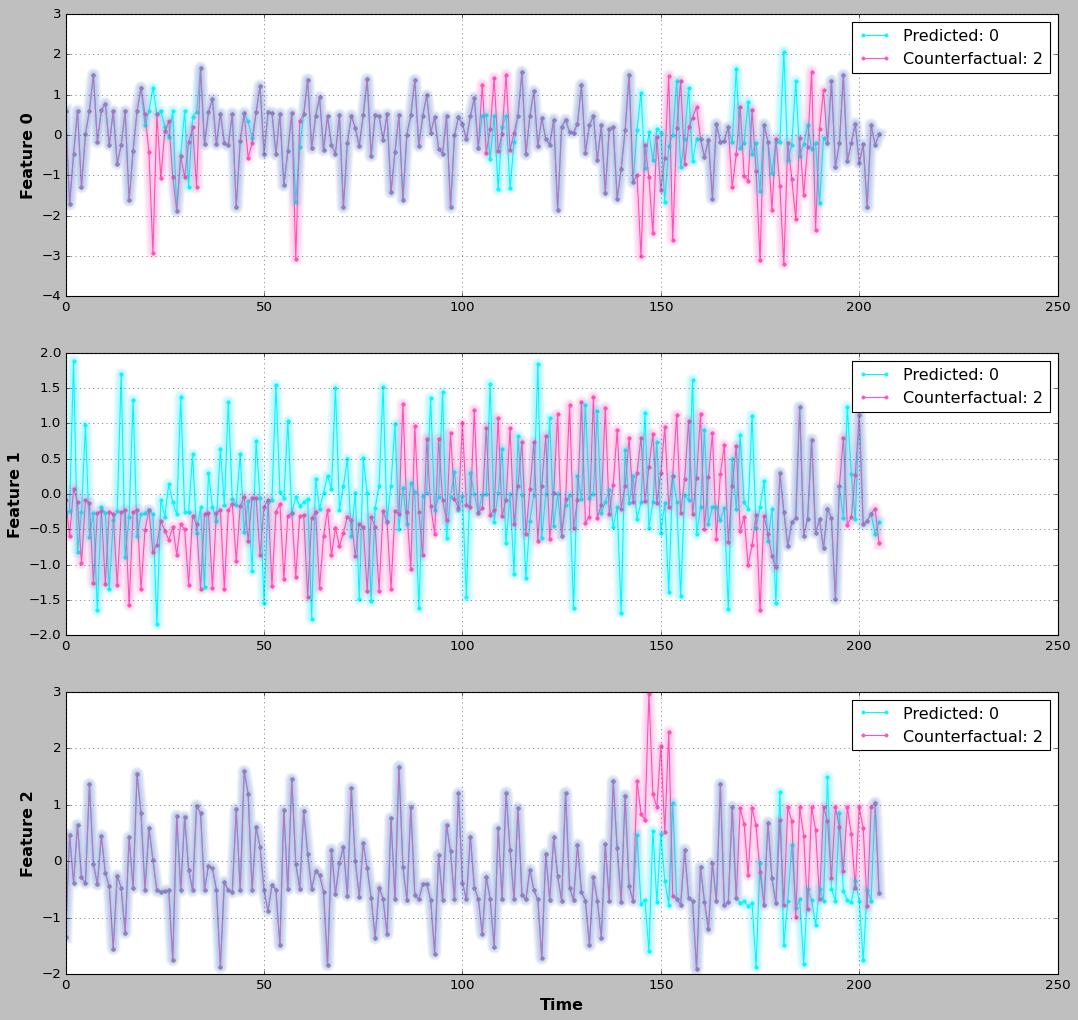

In [88]:
# Visualization of counterfactual

tsevo_exp.plot_in_one(observation_01,label_01[0],pop,np.argmax(label_cf),save_fig=f'./interp_figs/{model_name}_tsevo.png', figsize=(8*2,5*NumFeatures))

## 2. TSR_FA

In [89]:
from TSInterpret.InterpretabilityModels.Saliency.TSR import TSR, Saliency_PTY
tsr_FA_exp = Saliency_PTY(model, NumTimeSteps=NumTimesteps, NumFeatures=NumFeatures, method='FA', mode='feat', tsr=True)

In [90]:
observation_01.shape

(3, 206)

In [105]:
exp_fa = tsr_FA_exp.explain(observation_01[np.newaxis], labels=label_01,TSR = True, attribution=0.0)

In [106]:
exp_fa.shape

(3, 206)

True
NOT Time mode


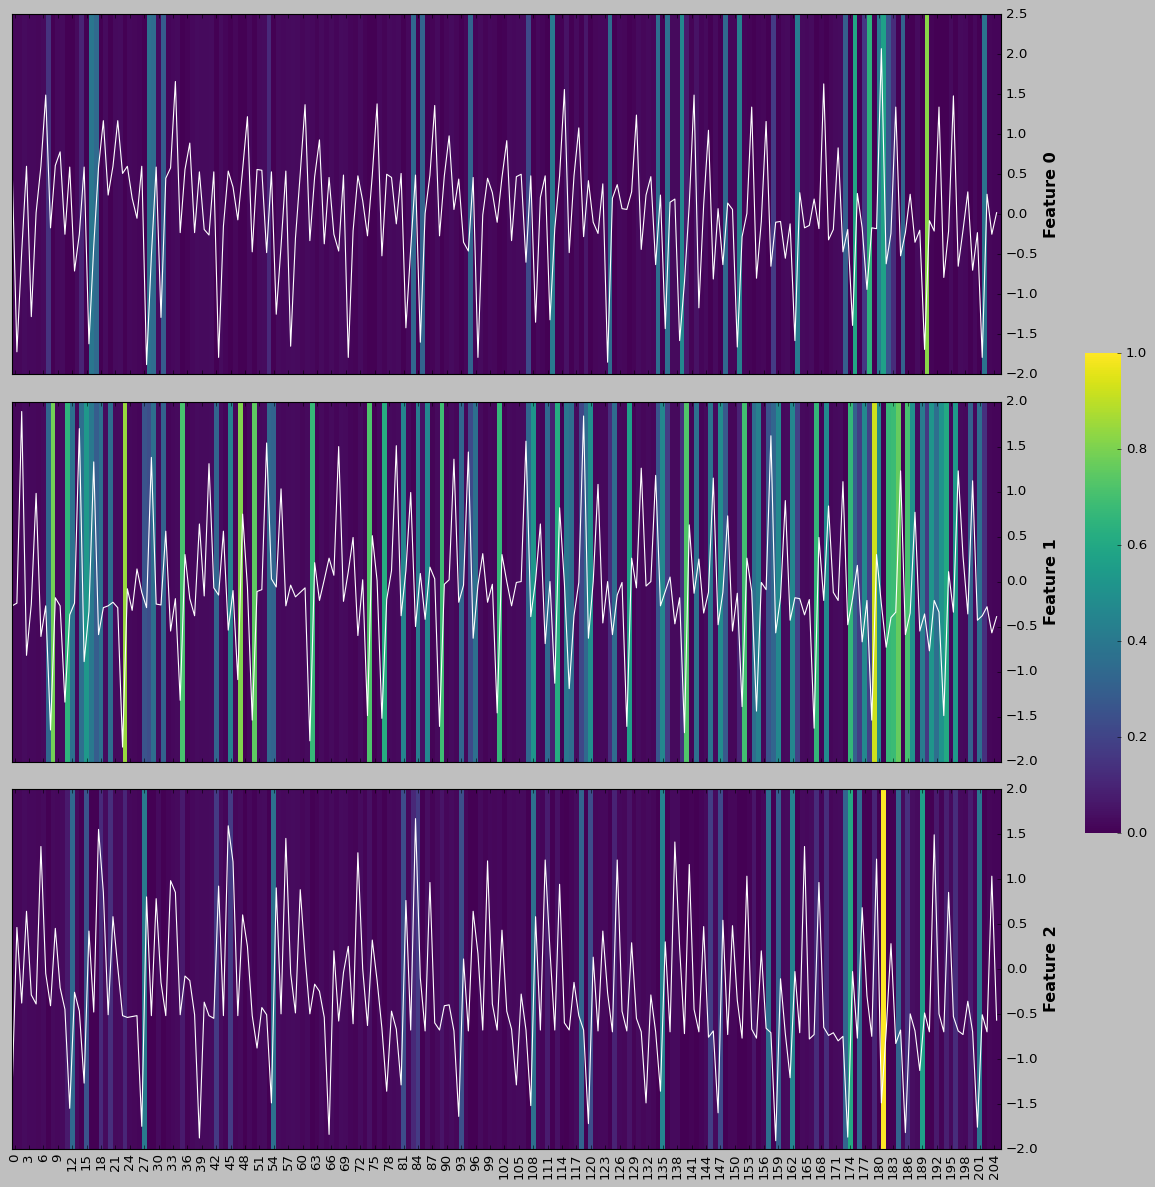

In [107]:
# Saliency heatmap

tsr_FA_exp.plot(observation_01[np.newaxis],exp_fa,figsize=(15,5*NumFeatures), save=f'./interp_figs/{model_name}_tsr_FA.png')


## 3. TSR_Grad

In [108]:
tsr_GRAD_exp = Saliency_PTY(model, NumTimeSteps=train_x.shape[-2], NumFeatures=train_x.shape[-1], method='GRAD', mode='feat', tsr=True)

In [109]:
exp_grad = tsr_GRAD_exp.explain(observation_01[np.newaxis], labels=label_01,TSR = True, attribution=0.0)

True
NOT Time mode


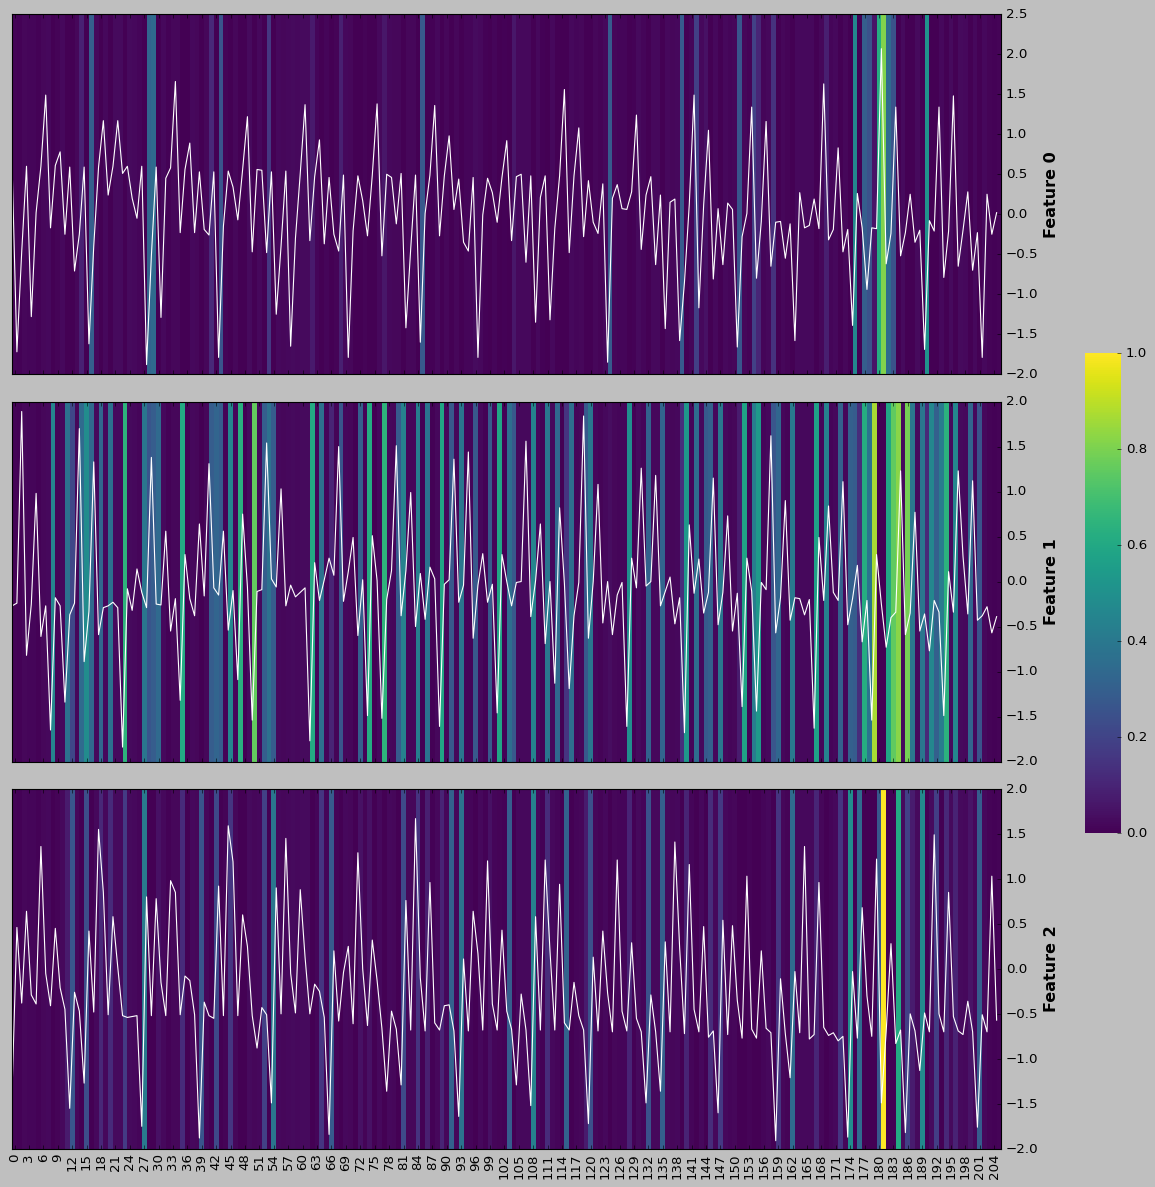

In [110]:

tsr_GRAD_exp.plot(observation_01[np.newaxis],exp_grad,figsize=(15,5*NumFeatures), save=f'./interp_figs/{model_name}_tsr_Grad.png')


## 4. TSR_FO

In [111]:
tsr_FO_exp =  Saliency_PTY(model, NumTimeSteps=train_x.shape[-2], NumFeatures=train_x.shape[-1], method='FO', mode='feat', tsr=True)

In [112]:
exp_fo = tsr_FO_exp.explain(observation_01[np.newaxis], labels=label_01,TSR = True, attribution=0.0)

True
NOT Time mode


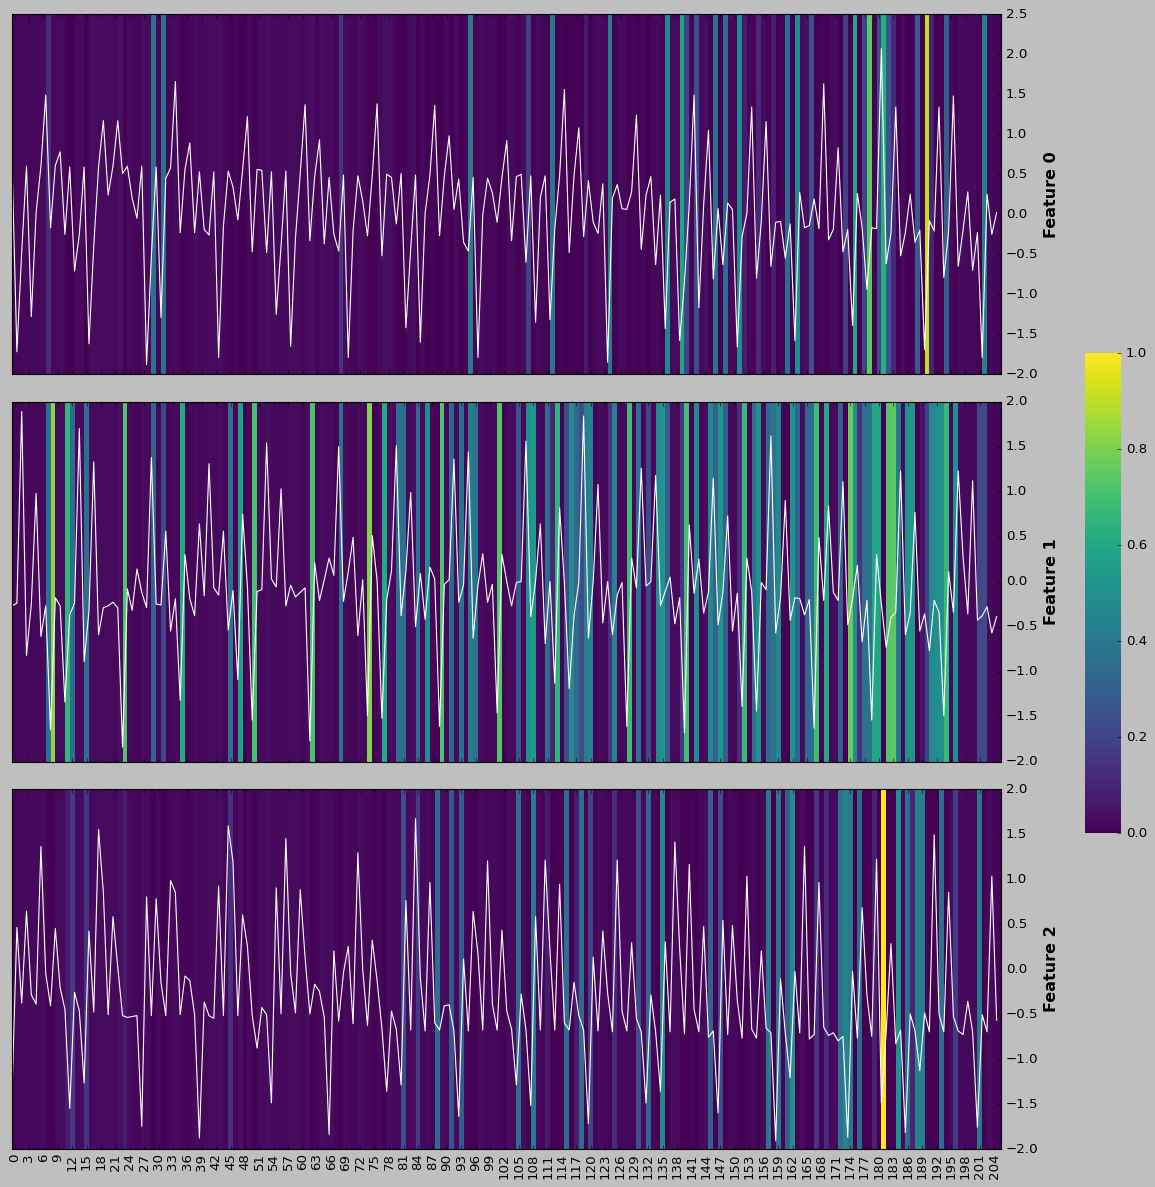

In [113]:
tsr_FO_exp.plot(observation_01[np.newaxis], exp_fo,figsize=(15,5*NumFeatures), save=f'./interp_figs/{model_name}_tsr_FO.png')